# Model Training Script
Install the snowflake-connector-python if needed

In [168]:
#!pip install snowflake-connector-python

In [85]:
import pandas as pd
import numpy as np
import snowflake.connector
import os
from datetime import datetime
from dotenv import load_dotenv
import argparse
import joblib
import argparse
import joblib
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


# enable pandas to display up to 500 columns
pd.set_option('display.max_columns', 500)

#### 1.1 Load Snowflake credentials for temp user

In [86]:
# Load environment variables from a .env file
load_dotenv()

try:
    TEMP_USER = os.getenv('SNOWSQL_TEMP_USER')
    TEMP_USER_PASSWORD = os.getenv('SNOWSQL_TEMP_PWD')
    
    if not TEMP_USER:
        raise ValueError("Environment variable SNOWSQL_TEMP_USER must be set")
    if not TEMP_USER_PASSWORD:
        raise ValueError("Environment variable SNOWSQL_TEMP_PWD must be set")

except ValueError as ve:
    print(f"Error: {ve}")
    
except Exception as e:
    print(f"An unexpected error occurred: {e}")

#### 1.2 Connect to Snowflake

In [87]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account='ygeuort-alb19263',
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='ODS'
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-07-24 15:4614


In [88]:
def get_data(sql_query, date_columns=None):
    """
    Executes a SQL query and returns the result as a pandas DataFrame.

    Args:
        sql_query (str): SQL query to execute.

    Returns:
        df_result: Resulting DataFrame from the SQL query.
    """
    try:
        cursor = conn.cursor()
        
        cursor.execute(sql_query)

        # load data into dataframe
        df_result = cursor.fetch_pandas_all()

        # Convert column names to lowercase
        df_result.columns = map(str.lower, df_result.columns)

        # Parse specified date columns
        if date_columns:
            for col in date_columns:
                df_result[col] = pd.to_datetime(df_result[col], errors='coerce')

    finally:
        if cursor is not None:
            cursor.close()

    return df_result

#### 2.2 Sample query
Select listings data for albany market.

In [161]:
sql_query = '''
select * from listings
 '''

df = get_data(sql_query)
df.shape

(111052, 68)

In [162]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [163]:
features = ['market', 'host_identity_verified', 'room_type', 'accommodates', 'bathrooms', 'beds']
categorical_features = ['market', 'room_type', 'host_identity_verified']
numerical_features = ['accommodates', 'bathrooms', 'beds']
target = 'price'

#filter to only the features and target columns
df = df[features + [target]]
# drop prices over 600 a night
df = df[df[target] <= 600]
# drop rows with missing target value
df = df.dropna(subset=[target])
X = df.drop(columns=[target])
y = df[target]

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Cross-validation MAE scores: [58.25337328 58.7410126  58.91110018 59.1612984  58.09765366]
Average cross-validation MAE: 58.63288762487275
Test set MAE: 58.67335381967918


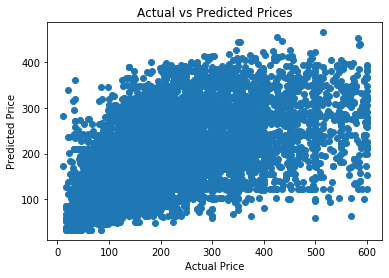

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

def create_pipeline():
    # Define the preprocessing for numerical features
    #numerical_features = ['num_feature1', 'num_feature2']  # replace with your actual numerical feature names
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Define the preprocessing for categorical features
    #categorical_features = ['cat_feature1', 'cat_feature2']  # replace with your actual categorical feature names
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing for numerical and categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # Create the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=50))
    ])
    
    return pipeline

# Create the pipeline
pipeline = create_pipeline()

# Perform cross-validation with MAE
maeScores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
maeScores = -maeScores  # Convert negative MAE to positive
print("Cross-validation MAE scores:", maeScores)
print("Average cross-validation MAE:", maeScores.mean())

# Train the model on the entire training set
pipeline.fit(X_train, y_train)

# Predict and evaluate the model on the test set using MAE
y_pred = pipeline.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)
print("Test set MAE:", mae_test)

# Save the model weights
joblib.dump(pipeline, 'regression_pipeline.joblib')

# Plot the results
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()



In [138]:
# Create a dataframe of target, predicted values, and difference
df_result = pd.DataFrame({'Target': y_test, 'Predicted': y_pred, 'Difference': y_test - y_pred})
# 58.63
# Display the dataframe
df_result


,Target,Predicted,Difference
33536,280.0,362.9375,-82.9375
10980,45.0,114.3750,-69.3750
4361,218.0,52.3125,165.6875
34835,69.0,159.8125,-90.8125
22170,200.0,125.0000,75.0000
...,...,...,...
25223,140.0,233.7500,-93.7500
29035,685.0,694.4375,-9.4375
22446,140.0,244.4375,-104.4375
34262,79.0,119.6875,-40.6875


#### 3.3 Connect to FEATURE_STORE schema

In [ ]:
# Establish connection to Snowflake
current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')

try:
    conn = snowflake.connector.connect(
        user=TEMP_USER,
        password=TEMP_USER_PASSWORD,
        account='ygeuort-alb19263',
        warehouse='COMPUTE_WH',
        database='AIRBNB',
        schema='FEATURE_STORE' # connect to feature_store
    )

    print(f'Connected to Snowflake successfully at {current_time}')

except Exception as e:
    print(f'Failed to connect to Snowflake on {current_time} due to error code {e}')

Connected to Snowflake successfully at 2024-07-24 14:4726


#### 3.4 Create table and upload to Snowflake

In [ ]:
from snowflake.connector.pandas_tools import write_pandas

In [ ]:
def write_to_snowflake(df_name, snowflake_table_name):
    current_time = datetime.now().strftime('%Y-%m-%d %H:%M%S')
    try:
        success, num_chunks, num_rows, output = write_pandas(
            conn=conn,
            df=df_name,
            schema='FEATURE_STORE', # schema needs to be capitalized
            table_name=snowflake_table_name,
            auto_create_table=True,
            overwrite=True
        )

        print(f'Created table and data loaded to Snowflake at {current_time}')

    except Exception as e:
        print(f'Failed to create table and load data to Snowflake due to error code {e}')

In [ ]:
write_to_snowflake(df, 'ALBANY_MARKET_LISTINGS')

Created table and data loaded to Snowflake at 2024-07-24 14:4726
